# 1️⃣ Create DB

In [1]:
import sqlite3

# Connect / create db
conn = sqlite3.connect("fleet01.db")
cursor = conn.cursor()

# drop table if it exists
cursor.execute("DROP TABLE IF EXISTS fuel_usage")
cursor.execute("DROP TABLE IF EXISTS vehicles")

# Create vehicles table
cursor.execute("""
CREATE TABLE vehicles (
    vehicle_id INTEGER PRIMARY KEY,
    type TEXT,
    plate TEXT,
    brand TEXT,
    region TEXT
)
""")

# Create fuel_usage table
cursor.execute("""
CREATE TABLE fuel_usage (
    record_id INTEGER PRIMARY KEY,
    vehicle_id INTEGER,
    month TEXT,
    fuel_cost REAL,
    km_driven REAL,
    fuel_type TEXT,
    FOREIGN KEY(vehicle_id) REFERENCES vehicles(vehicle_id)
)
""")

conn.commit()
conn.close()


# 2️⃣Imports + Connect

In [2]:
import sqlite3
import pandas as pd

# Connect to db
conn = sqlite3.connect("fleet01.db")

# SELECT tables
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,vehicles
1,fuel_usage


# 3️⃣ Insert Fake Data - Vehicles

In [3]:
import sqlite3
import random

conn = sqlite3.connect("fleet01.db")
cursor = conn.cursor()

# -----------------------------
# FAKE VEHICLES
vehicle_types = ["Car", "Van", "Truck"]
brands = ["Toyota", "Ford", "VW", "Volvo", "Renault", "Skoda"]
regions = ["Athens", "Thessaloniki", "Patras", "Heraklion"]

num_vehicles = 100
vehicles_data = []

for i in range(1, num_vehicles + 1):
    vehicles_data.append((
        i,
        random.choice(vehicle_types),
        f"XYZ-{1000+i}",
        random.choice(brands),
        random.choice(regions)
    ))

cursor.executemany(
    "INSERT INTO vehicles (vehicle_id, type, plate, brand, region) VALUES (?, ?, ?, ?, ?);",
    vehicles_data
)

# -----------------------------
# FAKE FUEL USAGE
months = ["2025-09", "2025-10", "2025-11", "2025-12", "2026-01"]
fuel_records = []
record_id = 1

for vehicle_id in range(1, num_vehicles + 1):
    for month in months:
        fuel_type = "Diesel" if random.random() > 0.5 else "Petrol"  # 50 - 50
        km = random.randint(700, 3000)
        fuel_cost = round(random.uniform(100, 500), 2)

        fuel_records.append((
            record_id,
            vehicle_id,
            month,
            fuel_cost,
            km,
            fuel_type
        ))
        record_id += 1

cursor.executemany(
    "INSERT INTO fuel_usage (record_id, vehicle_id, month, fuel_cost, km_driven, fuel_type) VALUES (?, ?, ?, ?, ?, ?);",
    fuel_records
)

conn.commit()





Fake data inserted successfully (50-50 fuel type)


# 4️⃣Check inserted data


In [6]:
import sqlite3

# Re-open the database connection
conn = sqlite3.connect("fleet01.db")

In [5]:
import pandas as pd
# Show the first 5 rows of the vehicles table
pd.read_sql("SELECT * FROM vehicles LIMIT 5;", conn)

# Show the first 5 rows of the fuel_usage table
pd.read_sql("SELECT * FROM fuel_usage LIMIT 5;", conn)

,record_id,vehicle_id,month,fuel_cost,km_driven,fuel_type
0,1,1,2025-09,157.72,2427.0,Diesel
1,2,1,2025-10,142.69,955.0,Petrol
2,3,1,2025-11,456.33,2734.0,Petrol
3,4,1,2025-12,288.56,1154.0,Diesel
4,5,1,2026-01,406.23,799.0,Diesel


# Data Loading

In [2]:
import sqlite3
import pandas as pd
from IPython.display import display

# Connect to SQLite database
conn = sqlite3.connect("fleet01.db")

# Load tables into DataFrames
vehicles_df = pd.read_sql("SELECT * FROM vehicles;", conn)
fuel_df = pd.read_sql("SELECT * FROM fuel_usage;", conn)

# Display both tables nicely
display(vehicles_df.head())
display(fuel_df.head())


,vehicle_id,type,plate,brand,region
0,1,Van,XYZ-1001,Volvo,Heraklion
1,2,Car,XYZ-1002,Toyota,Athens
2,3,Car,XYZ-1003,Ford,Athens
3,4,Van,XYZ-1004,Skoda,Patras
4,5,Car,XYZ-1005,Renault,Patras


,record_id,vehicle_id,month,fuel_cost,km_driven,fuel_type
0,1,1,2025-09,157.72,2427.0,Diesel
1,2,1,2025-10,142.69,955.0,Petrol
2,3,1,2025-11,456.33,2734.0,Petrol
3,4,1,2025-12,288.56,1154.0,Diesel
4,5,1,2026-01,406.23,799.0,Diesel


# Data Cleaning
Convert month to datetime and round up fuel_cost to nearest 10 for realism.


In [3]:
import numpy as np

# Convert month to datetime
fuel_df["month"] = pd.to_datetime(fuel_df["month"])

# Round up fuel_cost to the nearest 10
fuel_df["fuel_cost"] = np.ceil(fuel_df["fuel_cost"] / 10) * 10

# Quick preview
from IPython.display import display
display(vehicles_df.head())
display(fuel_df.head())


,vehicle_id,type,plate,brand,region
0,1,Van,XYZ-1001,Volvo,Heraklion
1,2,Car,XYZ-1002,Toyota,Athens
2,3,Car,XYZ-1003,Ford,Athens
3,4,Van,XYZ-1004,Skoda,Patras
4,5,Car,XYZ-1005,Renault,Patras


,record_id,vehicle_id,month,fuel_cost,km_driven,fuel_type
0,1,1,2025-09-01,160.0,2427.0,Diesel
1,2,1,2025-10-01,150.0,955.0,Petrol
2,3,1,2025-11-01,460.0,2734.0,Petrol
3,4,1,2025-12-01,290.0,1154.0,Diesel
4,5,1,2026-01-01,410.0,799.0,Diesel


# Make Synthetic Fuel Cost More Realistic (Region-Based Pricing)

In this step, fuel cost is recalculated based on:
- km driven
- fuel price range per region (1.60€ – 2.10€ / liter)
- basic fuel consumption assumptions per vehicle type
This makes the synthetic dataset closer to a real-world business scenario.


In [3]:
import numpy as np

# Fuel price per region: (Petrol, Diesel)
fuel_prices = {
    "Athens": (1.70, 1.50),
    "Thessaloniki": (1.80, 1.60),
    "Patras": (1.90, 1.75),
    "Heraklion": (2.00, 1.90)
}

# Consumption per 100km by vehicle type (example realistic values)
consumption_per_100km = {
    "Car": {"Petrol": 7, "Diesel": 6},
    "Van": {"Petrol": 9, "Diesel": 8}
}

# Merge region and type into fuel_df (αν δεν το έχεις ήδη)
fuel_df = fuel_df.merge(vehicles_df[["vehicle_id", "region", "type"]], on="vehicle_id", how="left")

# Calculate fuel cost per row
def calc_fuel_cost(row):
    fuel_type = row["fuel_type"]
    region = row["region"]
    vehicle_type = row["type"]
    
    # Get fuel price for region and type
    if region in fuel_prices:
        price_per_liter = fuel_prices[region][0] if fuel_type=="Petrol" else fuel_prices[region][1]
    else:
        price_per_liter = 1.8 if fuel_type=="Petrol" else 1.6  # default
    
    # Get consumption per 100km
    consumption = consumption_per_100km.get(vehicle_type, {"Petrol":7,"Diesel":6}).get(fuel_type,7)
    
    # fuel cost = km_driven / 100 * consumption * price_per_liter
    cost = row["km_driven"] / 100 * consumption * price_per_liter
    
    # Round to nearest 10
    cost = np.ceil(cost / 10) * 10
    return cost

fuel_df["fuel_cost"] = fuel_df.apply(calc_fuel_cost, axis=1)

# Quick preview
from IPython.display import display
display(fuel_df.head())


,record_id,vehicle_id,month,fuel_cost,km_driven,fuel_type,region,type
0,1,1,2025-09,370.0,2427.0,Diesel,Heraklion,Van
1,2,1,2025-10,180.0,955.0,Petrol,Heraklion,Van
2,3,1,2025-11,500.0,2734.0,Petrol,Heraklion,Van
3,4,1,2025-12,180.0,1154.0,Diesel,Heraklion,Van
4,5,1,2026-01,130.0,799.0,Diesel,Heraklion,Van


# Quick Sanity Check and Basic EDA

Before any analysis or modeling, we perform basic sanity checks to ensure data quality:
1. Check for missing values
2. Get descriptive statistics for numeric columns
3. Explore unique fuel types

In [6]:
# Check for missing values in both tables
missing_vehicles = vehicles_df.isnull().sum()
missing_fuel = fuel_df.isnull().sum()

print("Missing values in vehicles table:\n", missing_vehicles)
print("\nMissing values in fuel_usage table:\n", missing_fuel)


Missing values in vehicles table:
 vehicle_id    0
type          0
plate         0
brand         0
region        0
dtype: int64

Missing values in fuel_usage table:
 record_id     0
vehicle_id    0
month         0
fuel_cost     0
km_driven     0
fuel_type     0
region        0
type          0
dtype: int64


In [7]:
# Numeric summary for fuel_usage
# .round(0) else .000000
fuel_numeric_stats = fuel_df[["fuel_cost", "km_driven"]].describe().round(0)
fuel_numeric_stats


,fuel_cost,km_driven
count,500.0,500.0
mean,237.0,1805.0
std,99.0,673.0
min,70.0,702.0
25%,160.0,1228.0
50%,230.0,1746.0
75%,300.0,2378.0
max,540.0,3000.0


## Visual EDA

Explore trends and distributions in fuel usage and distance driven:
1. Total fuel cost per month
2. Total km driven per vehicle
3. Fuel type distribution


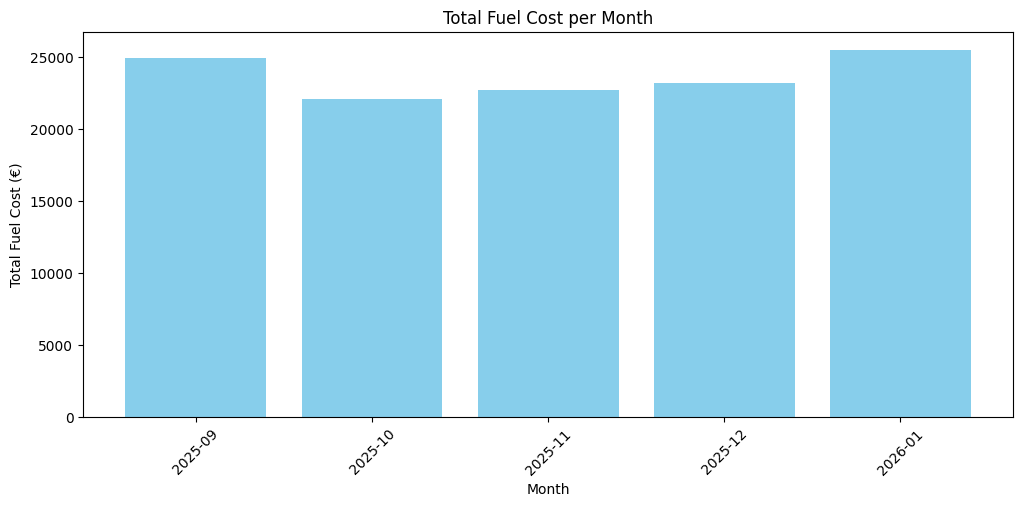

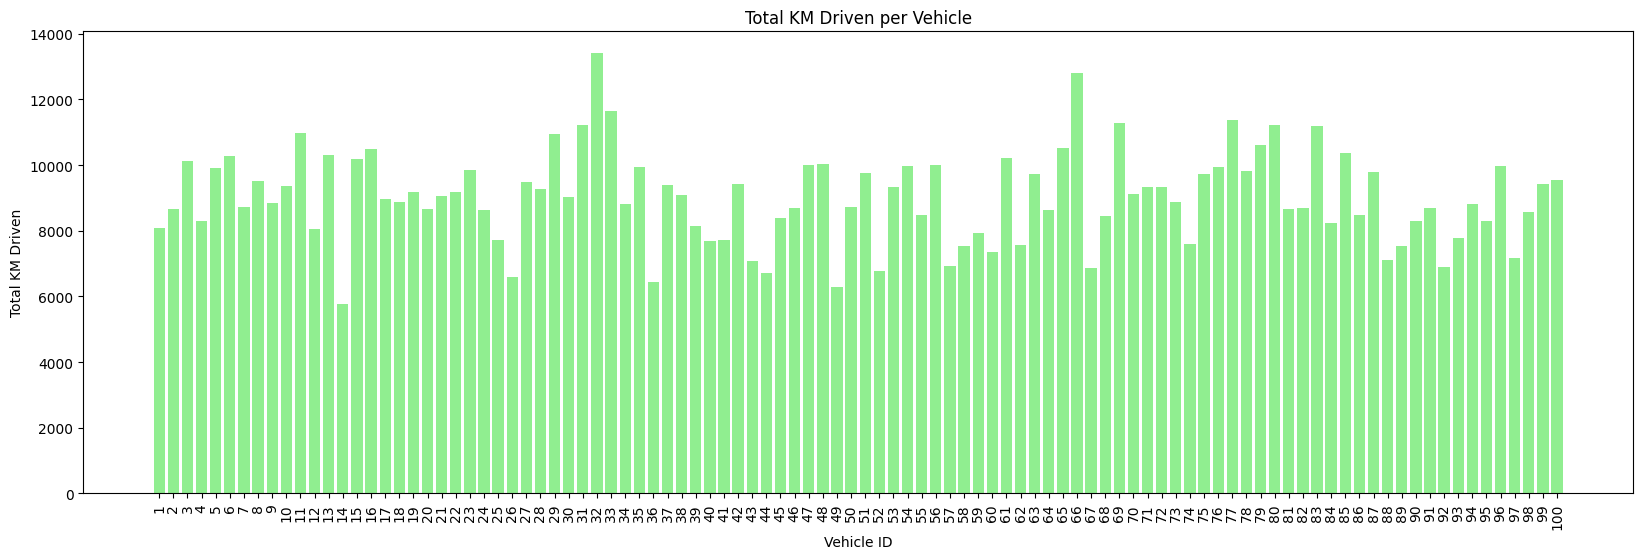

In [11]:
import matplotlib.pyplot as plt

# 1️⃣ Total fuel cost per month
month_cost = fuel_df.groupby("month")["fuel_cost"].sum()
month_labels = month_cost.index  # είναι string YYYY-MM

plt.figure(figsize=(12,5))
plt.bar(month_labels, month_cost.values, color="skyblue")
plt.title("Total Fuel Cost per Month")
plt.xlabel("Month")
plt.ylabel("Total Fuel Cost (€)")
plt.xticks(rotation=45)
plt.show()

# 2️⃣ Total km driven per vehicle (πιο καθαρό)
vehicle_km = fuel_df.groupby("vehicle_id")["km_driven"].sum()

plt.figure(figsize=(20,6))  # μεγαλύτερη εικόνα για να χωράνε οι 100+ vehicles
plt.bar(vehicle_km.index.astype(str), vehicle_km.values, color="lightgreen")
plt.title("Total KM Driven per Vehicle")
plt.xlabel("Vehicle ID")
plt.ylabel("Total KM Driven")
plt.xticks(rotation=90)  # κάθετα για να φαίνονται όλοι οι ID
plt.show()




